In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense
from sklearn.metrics import mean_squared_error
import math

Step 1: Download and load the dataset

In [2]:
url = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/monthly-sunspots.csv'
data = pd.read_csv(url, usecols=[1])  # use only the sunspot count column

In [3]:
data.head()

,Sunspots
0,58.0
1,62.6
2,70.0
3,55.7
4,85.0


Step 2: Scale data between 0 and 1

In [4]:
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data)

Step 3: Prepare input-output pairs for time series (window size=12 months)

In [5]:
def create_dataset(dataset, window=12):
    X, y = [], []
    for i in range(len(dataset) - window):
        X.append(dataset[i:i + window, 0])
        y.append(dataset[i + window, 0])
    X = np.array(X)
    y = np.array(y)
    return np.reshape(X, (X.shape[0], X.shape[1], 1)), y  # reshape for RNN [samples, time steps, features]

X, y = create_dataset(data_scaled, 12)

Step 4: Split into train (80%) and test (20%) sets

In [6]:
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

Step 5: Build the SimpleRNN model

In [7]:
model = Sequential()
model.add(SimpleRNN(units=10, activation='tanh', input_shape=(12, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

c:\Users\cheta\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


 Step 6: Train the model for 20 epochs (batch size 1)

In [8]:
history = model.fit(X_train, y_train, epochs=20, batch_size=1, validation_data=(X_test, y_test), verbose=2)

Epoch 1/20
2246/2246 - 5s - 2ms/step - loss: 0.0050 - val_loss: 0.0070
Epoch 2/20
2246/2246 - 4s - 2ms/step - loss: 0.0038 - val_loss: 0.0057
Epoch 3/20
2246/2246 - 4s - 2ms/step - loss: 0.0037 - val_loss: 0.0058
Epoch 4/20
2246/2246 - 4s - 2ms/step - loss: 0.0037 - val_loss: 0.0055
Epoch 5/20
2246/2246 - 4s - 2ms/step - loss: 0.0036 - val_loss: 0.0059
Epoch 6/20
2246/2246 - 4s - 2ms/step - loss: 0.0036 - val_loss: 0.0063
Epoch 7/20
2246/2246 - 5s - 2ms/step - loss: 0.0037 - val_loss: 0.0074
Epoch 8/20
2246/2246 - 4s - 2ms/step - loss: 0.0036 - val_loss: 0.0056
Epoch 9/20
2246/2246 - 4s - 2ms/step - loss: 0.0037 - val_loss: 0.0066
Epoch 10/20
2246/2246 - 4s - 2ms/step - loss: 0.0036 - val_loss: 0.0055
Epoch 11/20
2246/2246 - 4s - 2ms/step - loss: 0.0036 - val_loss: 0.0079
Epoch 12/20
2246/2246 - 4s - 2ms/step - loss: 0.0036 - val_loss: 0.0064
Epoch 13/20
2246/2246 - 4s - 2ms/step - loss: 0.0036 - val_loss: 0.0063
Epoch 14/20
2246/2246 - 4s - 2ms/step - loss: 0.0036 - val_loss: 0.0066
E

In [9]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, 10)             │           120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 395 (1.55 KB)

 Trainable params: 131 (524.00 B)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 264 (1.04 KB)

Step 7: Predictions and evaluation

In [10]:
train_pred = model.predict(X_train)
test_pred = model.predict(X_test)

71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Inverse scale to original values for RMSE calculation

In [11]:
train_pred_rescaled = scaler.inverse_transform(train_pred)
y_train_rescaled = scaler.inverse_transform(y_train.reshape(-1, 1))
test_pred_rescaled = scaler.inverse_transform(test_pred)
y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))

train_rmse = math.sqrt(mean_squared_error(y_train_rescaled, train_pred_rescaled))
test_rmse = math.sqrt(mean_squared_error(y_test_rescaled, test_pred_rescaled))

print(f'Train RMSE: {train_rmse:.3f}')
print(f'Test RMSE: {test_rmse:.3f}')

Train RMSE: 14.780
Test RMSE: 18.927


Step 8: Plot RMSE for train and test sets

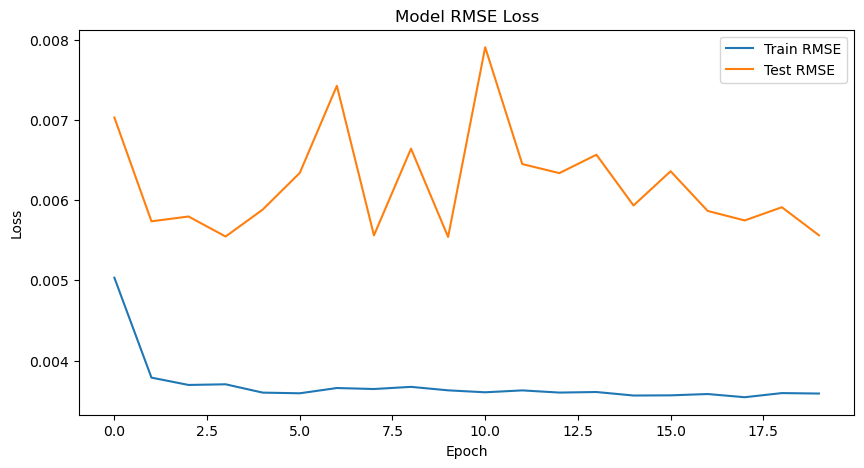

In [12]:
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train RMSE')
plt.plot(history.history['val_loss'], label='Test RMSE')
plt.title('Model RMSE Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

Step 9: Visualize predictions vs true values on test set

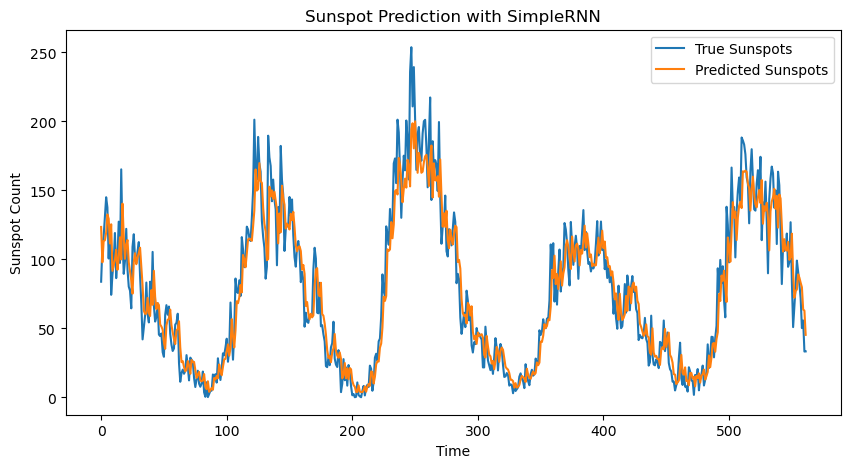

In [13]:
plt.figure(figsize=(10, 5))
plt.plot(y_test_rescaled, label='True Sunspots')
plt.plot(test_pred_rescaled, label='Predicted Sunspots')
plt.title('Sunspot Prediction with SimpleRNN')
plt.ylabel('Sunspot Count')
plt.xlabel('Time')
plt.legend()
plt.show()